# 1. Imports with error handling

In [2]:
# 1. Imports with error handling
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
from datetime import datetime

sns.set(style='whitegrid')


# 2. Load data with proper JSON handling

In [3]:
# 2. Load data with proper JSON handling
def load_json_safely(filepath):
    """Handle JSON loading with proper datetime conversion"""
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # Convert string dates to datetime
    if 'change_point_date' in data:
        data['change_point_date'] = pd.to_datetime(data['change_point_date'])
    if 'price_data' in data:
        for item in data['price_data']:
            item['Date'] = pd.to_datetime(item['Date'])
    return data

try:
    change_point_results = load_json_safely('change_point_results.json')
    events_df = pd.read_csv('../data/processed/events_processed.csv')
    price_df = pd.read_csv('../data/processed/brent_processed.csv')
    
    # Convert all date columns
    events_df['Event_date'] = pd.to_datetime(events_df['Event_date'])
    price_df['Date'] = pd.to_datetime(price_df['Date'])
    
    print("✅ Data loaded successfully!")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise


✅ Data loaded successfully!


# 3. Create analysis DataFrame

In [4]:
# 3. Create analysis DataFrame
try:
    # Reconstruct price data from JSON if needed
    if 'price_data' in change_point_results:
        price_data_from_json = pd.DataFrame(change_point_results['price_data'])
        price_data_from_json['Date'] = pd.to_datetime(price_data_from_json['Date'])
    
    # Merge with events data
    analysis_df = pd.merge_asof(
        price_df.sort_values('Date'),
        events_df.sort_values('Event_date'),
        left_on='Date',
        right_on='Event_date',
        direction='nearest',
        tolerance=pd.Timedelta('7d')  # Events within 7 days
    )
    
    # Add change point info
    change_date = pd.to_datetime(change_point_results['change_point_date'])
    analysis_df['is_change_point'] = analysis_df['Date'] == change_date
    
except Exception as e:
    print(f"❌ Error creating analysis DataFrame: {e}")
    raise

# 4. Visualization

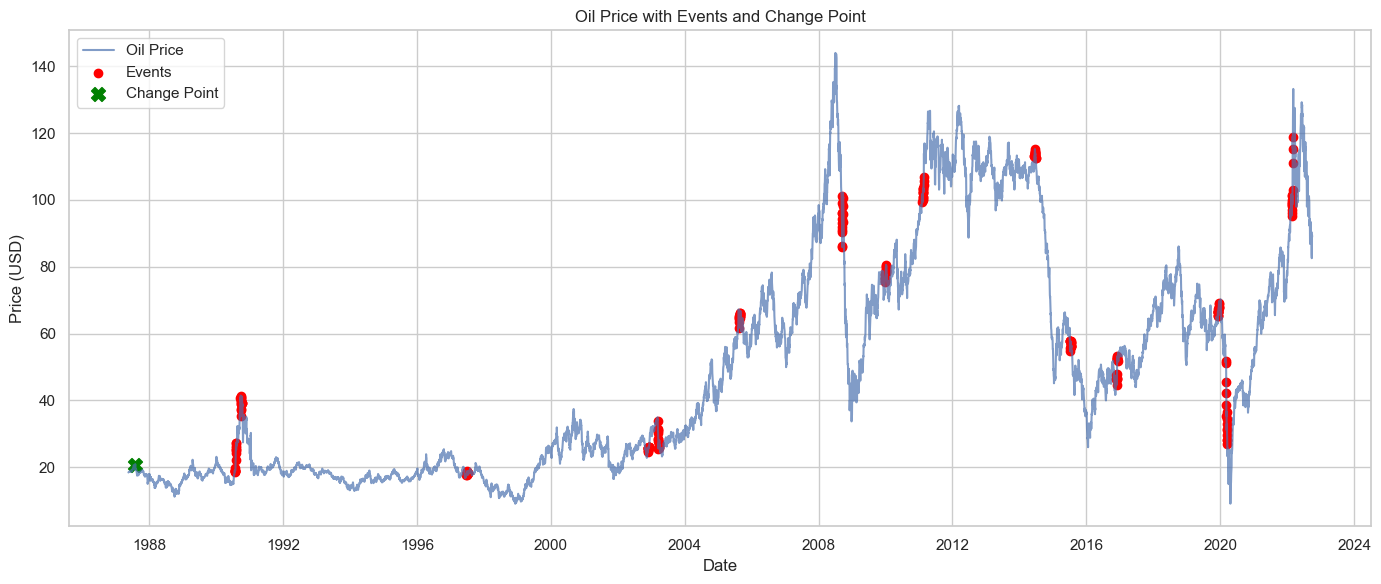

In [5]:
# 4. Visualization
plt.figure(figsize=(14, 6))

# Price trend
plt.plot(analysis_df['Date'], analysis_df['Price'], label='Oil Price', alpha=0.7)

# Events
event_mask = ~analysis_df['Event_name'].isna()
plt.scatter(
    analysis_df.loc[event_mask, 'Date'],
    analysis_df.loc[event_mask, 'Price'],
    color='red',
    label='Events'
)

# Change point
if 'is_change_point' in analysis_df.columns:
    cp_mask = analysis_df['is_change_point']
    plt.scatter(
        analysis_df.loc[cp_mask, 'Date'],
        analysis_df.loc[cp_mask, 'Price'],
        color='green',
        marker='X',
        s=100,
        label='Change Point'
    )

plt.title("Oil Price with Events and Change Point")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 5. Event Impact Analysis

In [6]:
# 5. Event Impact Analysis
def calculate_event_impact(price_df, events_df, window_days=5):
    """Calculate price impact around events"""
    impacts = []
    
    for _, event in events_df.iterrows():
        event_date = event['Event_date']
        
        # Pre-event window
        pre_mask = (price_df['Date'] >= event_date - pd.Timedelta(days=window_days)) & \
                   (price_df['Date'] < event_date)
        pre_avg = price_df.loc[pre_mask, 'Price'].mean()
        
        # Post-event window
        post_mask = (price_df['Date'] > event_date) & \
                    (price_df['Date'] <= event_date + pd.Timedelta(days=window_days))
        post_avg = price_df.loc[post_mask, 'Price'].mean()
        
        if not np.isnan(pre_avg) and not np.isnan(post_avg):
            impacts.append({
                'event': event['Event_name'],
                'date': event_date,
                'pre_price': pre_avg,
                'post_price': post_avg,
                'abs_change': post_avg - pre_avg,
                'pct_change': (post_avg - pre_avg) / pre_avg * 100
            })
    
    return pd.DataFrame(impacts)

# Calculate impacts
event_impacts = calculate_event_impact(price_df, events_df)
significant_events = event_impacts[
    (event_impacts['pct_change'].abs() > 2) | 
    (event_impacts['abs_change'].abs() > 2)
].sort_values('pct_change', ascending=False)

# Display results
print("Most Impactful Events:")
display(significant_events.style.format({
    'pre_price': '${:.2f}',
    'post_price': '${:.2f}',
    'abs_change': '${:.2f}',
    'pct_change': '{:.2f}%',
    'date': lambda x: x.strftime('%Y-%m-%d')
}))


Most Impactful Events:


,event,date,pre_price,post_price,abs_change,pct_change
0,Gulf War Begins,1990-08-02,$19.23,$26.03,$6.80,35.38%
11,OPEC Production Cut Announcement,2016-11-30,$46.12,$52.72,$6.60,14.30%
14,Russia-Ukraine Conflict,2022-02-24,$98.42,$102.84,$4.42,4.49%
7,US Shale Boom,2010-01-01,$77.00,$79.14,$2.14,2.78%
5,Hurricane Katrina,2005-08-23,$64.38,$65.67,$1.29,2.00%
6,Global Financial Crisis,2008-09-15,$94.24,$90.41,$-3.83,-4.06%
1,Asian Oil Crisis,1990-10-01,$40.65,$37.67,$-2.98,-7.33%
4,Iraq War Starts,2003-03-20,$29.83,$26.31,$-3.52,-11.80%
13,COVID-19 Pandemic Declared,2020-03-11,$39.70,$30.63,$-9.08,-22.86%


# 6. Save Results

In [8]:
# 6. Save Results
output = {
    'change_point': change_point_results['change_point_date'],
    'significant_events': significant_events.to_dict('records'),
    'analysis_performed': datetime.now().isoformat()
}

try:
    with open('event_correlation_results.json', 'w') as f:
        json.dump(output, f, indent=2, default=str)
    print("✅ Results saved successfully!")
except Exception as e:
    print(f"❌ Error saving results: {e}")


✅ Results saved successfully!
